In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split


In [3]:
dt_clf = DecisionTreeClassifier(random_state=37)

In [4]:
iris_data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris_data.data, iris_data.target, test_size = 0.2, random_state=37)

In [5]:
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=37, splitter='best')

## graph화 시키기

In [7]:
from sklearn.tree import export_graphviz

# export_graphviz()의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성함
export_graphviz(dt_clf, out_file='tree.dot', class_names = iris_data.target_names, feature_names = iris_data.feature_names, impurity=True, filled = True)

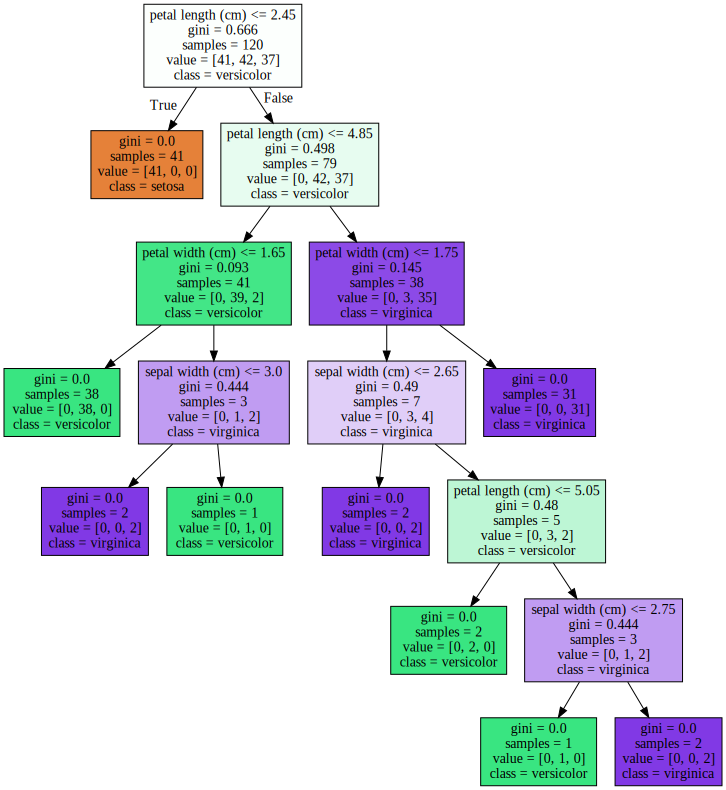

In [8]:
import graphviz

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

## feature_importances_

Feature importances:
[0.    0.046 0.897 0.057]
sepal length (cm) : 0.000
sepal width (cm) : 0.046
petal length (cm) : 0.897
petal width (cm) : 0.057


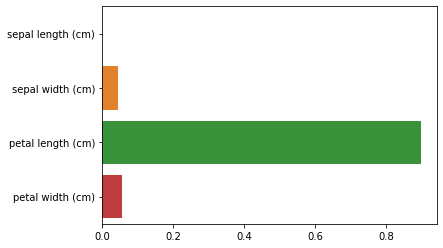

In [9]:
# feature importance 추출
print("Feature importances:\n{0}".format(np.round(dt_clf.feature_importances_, 3)))

# feature별 importance 매핑
for name, value in zip(iris_data.feature_names, dt_clf.feature_importances_):
    print("{0} : {1:.3f}".format(name, value))

# feature importance를 column 별로 시각화하기
sns.barplot(x=dt_clf.feature_importances_, y = iris_data.feature_names)

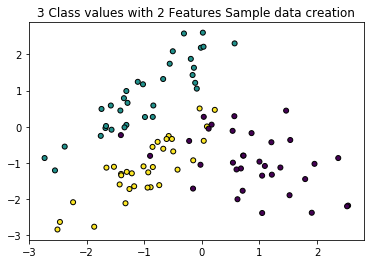

In [10]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
%matplotlib inline

plt.title("3 Class values with 2 Features Sample data creation")

X_features, y_labels = make_classification(n_features=2, n_redundant=0, n_informative=2,
                                          n_classes=3, n_clusters_per_class=1,random_state=37)

plt.scatter(X_features[:, 0], X_features[:, 1], marker='o', c=y_labels, s=25, edgecolor='k')

In [11]:
import numpy as np

# Classifier의 Decision Boundary를 시각화 하는 함수
def visualize_boundary(model, X, y):
    fig,ax = plt.subplots()
    
    # 학습 데이타 scatter plot으로 나타내기
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap='rainbow', edgecolor='k',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim_start , xlim_end = ax.get_xlim()
    ylim_start , ylim_end = ax.get_ylim()
    
    # 호출 파라미터로 들어온 training 데이타로 model 학습 . 
    model.fit(X, y)
    # meshgrid 형태인 모든 좌표값으로 예측 수행. 
    xx, yy = np.meshgrid(np.linspace(xlim_start,xlim_end, num=200),np.linspace(ylim_start,ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # contourf() 를 이용하여 class boundary 를 visualization 수행. 
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='rainbow', clim=(y.min(), y.max()),
                           zorder=1)

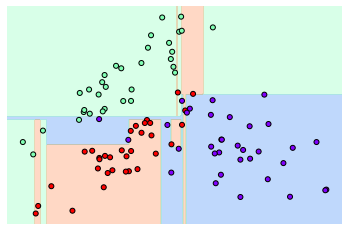

In [12]:
from sklearn.tree import DecisionTreeClassifier

# 특정한 트리 생성 제약없는 결정 트리의 Decsion Boundary 시각화.
dt_clf = DecisionTreeClassifier().fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

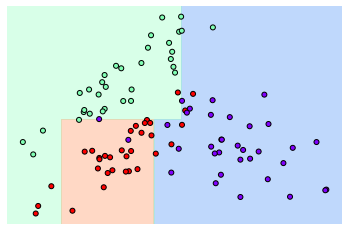

In [13]:
# min_sample_leaf=6으로 트리 생성 조건을 제약한 결정 경계 시각화
dt_clf = DecisionTreeClassifier(min_samples_leaf=6).fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

## 결정 트리 실습 - 사용자 행동 인식 데이터 세트

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

feature_name_df = pd.read_csv('data/human_activity/features.txt', sep='\s+',
                             header=None, names=['column_index', 'column_name'])

# 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 셈플로 10개만 추출
feature_name = feature_name_df.iloc[:, 1]. values.tolist()
print("전체 피처명에서 10개만 추출:", feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [20]:
feature_dup_df = feature_name_df.groupby("column_name").count()
print(feature_dup_df[feature_dup_df['column_index'] > 1].count())
feature_dup_df[feature_dup_df['column_index'] > 1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [21]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name',
                                                             'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                                                              if x[1] >0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [24]:
import pandas as pd

def get_human_dataset():
    feature_name_df = pd.read_csv('data/human_activity/features.txt', sep='\s+',
                             header=None, names=['column_index', 'column_name'])
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    X_train = pd.read_csv('data/human_activity/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('data/human_activity/test/X_test.txt', sep='\s+', names=feature_name)
    
    y_train = pd.read_csv('data/human_activity/train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('data/human_activity/test/y_test.txt', sep='\s+', header=None, names=['action'])
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [26]:
print("## 학습 피처 데이터셋 info()")
print(X_train.info())

## 학습 피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [27]:
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state = 37)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)

print("결정 트리 예측 정확도: {0:.4f}".format(accuracy))

# DecisionTreeClassifier의 하이퍼 파라미터 추출
print("DecisionTreeClassifier 기본 하이퍼 파라미터:\n", dt_clf.get_params())

결정 트리 예측 정확도: 0.8551
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 37, 'splitter': 'best'}


In [29]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [6, 8, 10, 12, 16, 20, 24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train,y_train)
print("GridSearchCV 최고 평균 정확도 수치: {0:.4f}".format(grid_cv.best_score_))
print("GridSearchCV 최적 하이퍼 파라미터:", grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.3min finished


GridSearchCV 최고 평균 정확도 수치: 0.8556
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8}


In [30]:
# GridSearchCV 객체의 cv_results_ 속성을 DataFrame으로 생성.
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

# max_depth 파라미터 값과 그때의 테스트 세트, 학습 데이터 세트의 정확도 수치 추출
cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.846846
1,8,0.855558
2,10,0.854880
3,12,0.841144
4,16,0.847807
5,20,0.844951
6,24,0.849030


In [32]:
max_depths = [6, 8, 10, 12, 16, 20, 24]

# max_depth 값을 변화시키면서 그때마다 학습과 테스트 세트에서의 예측 성능 측정
for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, random_state=37)
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print("max_depth = {0} 정확도: {1:.4f}".format(depth, accuracy))

max_depth = 6 정확도: 0.8554
max_depth = 8 정확도: 0.8721
max_depth = 10 정확도: 0.8633
max_depth = 12 정확도: 0.8666
max_depth = 16 정확도: 0.8595
max_depth = 20 정확도: 0.8551
max_depth = 24 정확도: 0.8551


In [34]:
params = {
    'max_depth' : [6, 8, 10, 12, 16, 20, 24],
    'min_samples_split' : [16, 24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train,y_train)
print("GridSearchCV 최고 평균 정확도 수치: {0:.4f}".format(grid_cv.best_score_))
print("GridSearchCV 최적 하이퍼 파라미터:", grid_cv.best_params_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  2.5min finished


GridSearchCV 최고 평균 정확도 수치: 0.8541
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 10, 'min_samples_split': 24}


## 최적 파라미터 estimator로 학습

In [37]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred1)
print("결정 트리 예측 정확도:{0:.4f}".format(accuracy))

결정 트리 예측 정확도:0.8629


## 최적 파라미터일때 피처 별 정확도

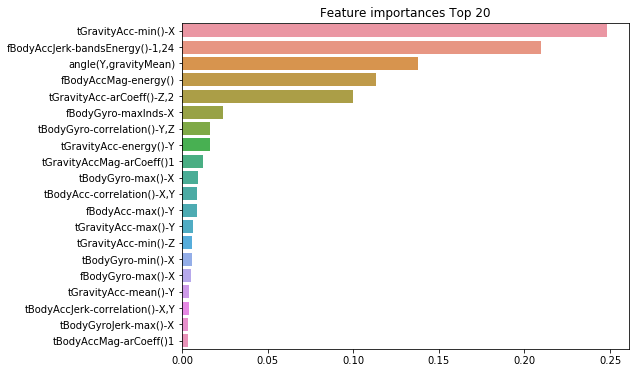

In [38]:
import seaborn as sns

ftr_importances_values = best_df_clf.feature_importances_
# Top 중요도로 정렬을 쉽게 하고, 시본(Seaborn)의 막대그래프로 쉽게 표현하기 위해 Series 변환
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
# 중요도값 순으로 Series를 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8, 6))
plt.title("Feature importances Top 20")
sns.barplot(x=ftr_top20, y = ftr_top20.index)
plt.show()